<a href="https://colab.research.google.com/github/pastrop/kaggle/blob/master/Emails_Processing_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Email Analysis Notebook

*Scope*


*   The below analysis is focused on text data as opposed to the information regarding to message routing as well as any any network related information available in the headers
*   Spam Folder is ignored - It is always more efficient to get a better spam filter as opposed to analyzing the spam folder
*   Calender and Contact folders are ignored - The data in those folders are significantly different than email message's data.  Besides those folders are really small
*   



*Approach*

*   Word Embeddings are used for the email text analysis
*   TSNE and Enbedding Projector are used for data visual analysis of the data
*   LDA - Latent Dirichle Allocation is used for the Topic Modelling
*   K-means is used for clustering (embeddings base) <br>

*Findings*


*   There is no clear clustering for the date
*   There is a significant differences in groupings based on the LDA topics vs K-means (based on PCA embedding transform) Further, there is a significant change in data clustering after running PCA from 768 dimensions to 2.  2 and 768 dimensional clusters are different in terms of which data point goes where. I believe it is an indication that the majority of the data is evenly distributed. This hypothesis is confirmed by visualization
*   Embeddings Projector is cool :)













# Email Parsing & Initial Processing

In [1]:
#Imports
import pandas as pd
import numpy as np
import re
import io
from pathlib import Path

In [48]:
!rm -rf contacts_test/

In [2]:
# file upload while using Google Colab
from google.colab import files
uploaded = files.upload()

Saving Alaffia_Data.zip to Alaffia_Data.zip


In [ ]:
# files unzipping
!unzip Alaffia_Data.zip

In [20]:
paths = Path('./Alaffia_Data').glob('**/[!.]*.*')
#paths = Path('/content/all_documents').glob('**/[!.]*')
msg = []

for path in paths:
    with io.open(path, 'r', errors='ignore') as file:
      msg.append(file.read())

In [21]:
len(msg)

6645

In [22]:
#message processing
# stipped off everything except "to" "from" and the message text
def parse_raw_message(raw_message):
    lines = raw_message.split('\n')
    email = {}
    message = ''
    keys_to_extract = ['from', 'to']
    for line in lines:
        if ':' not in line:
            if not re.findall(r"[a-z0-9\.\-+_]+@[a-z0-9\.\-+_]+\.[a-z]+", line) and \
            not re.findall(r"(\.com|\.org|IMAP|ESMTP|(EDT)|(ICT))", line): 
              message += line.strip()
              email['body'] = message
        else:
            pairs = line.split(':')
            key = pairs[0].lower()
            val = pairs[1].strip()
            if key in keys_to_extract:
                email[key] = val+' ' # to make combined labels readable
    return email

def parse_into_emails(messages):
  emails = [parse_raw_message(message) for message in messages]
  return {'body': map_to_list(emails, 'body'), 
          'to': map_to_list(emails, 'to'), 
          'from': map_to_list(emails, 'from')
          }

def map_to_list(dct, key):
  tmp = []
  for item in dct:
    try:
      tmp.append(item[key])
    except Exception:
      tmp.append('empty_field')  
  return tmp 

In [23]:
#getting the message text and forming the label
res = parse_into_emails(msg)
# lst of labels for the Embedding Projector
labels = [str(x)+str(y) for x,y in zip(res['from'], res['to'])] # str()  is just to make sure bcs the data is pretty dirty

In [ ]:
#text processing
import string
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
#from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

In [26]:
#dealing with punctions while preventing word merging the words(people don't put blanks where they should...)
tmp = []
for item in res['body']:
  temp = item.translate(str.maketrans(',.', '  '))
  tmp.append(temp.translate(str.maketrans('', '', string.punctuation)))
res['body'] = tmp  

# Modelling & Analysis

**Clustering - Visual Analysis**

In [27]:
!pip install -q tensorflow-hub
import tensorflow_hub as hub

In [28]:
# data visualization:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [29]:
#using universal sentence encoder to get sentence encodings
#Load the Universal Sentence Encoder's TF Hub module
#param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" # Using DAN
print ("module {} loaded".format(module_url))
model = hub.load(module_url)
def embed(input):
  return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [30]:
embedding_tuples = []
for item, label in zip(res['body'], labels):
  tmp = embed([item])[0].numpy(),label
  embedding_tuples.append(tmp)

In [31]:
# visualization code for a quick view of messages distribution (embeddings based)
def tsne_plot(emb):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for i in range(len(emb)):
        tokens.append(emb[i][0])
        labels.append(emb[i][1])
    
    tsne_model = TSNE(perplexity=30, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    print(f'number of points - {len(x)}')

    plt.figure(figsize=(16, 16)) 

    for i in range(len(x)):
        plt.scatter(x[i],y[i])
    plt.show()
    return x,y

number of points - 6645


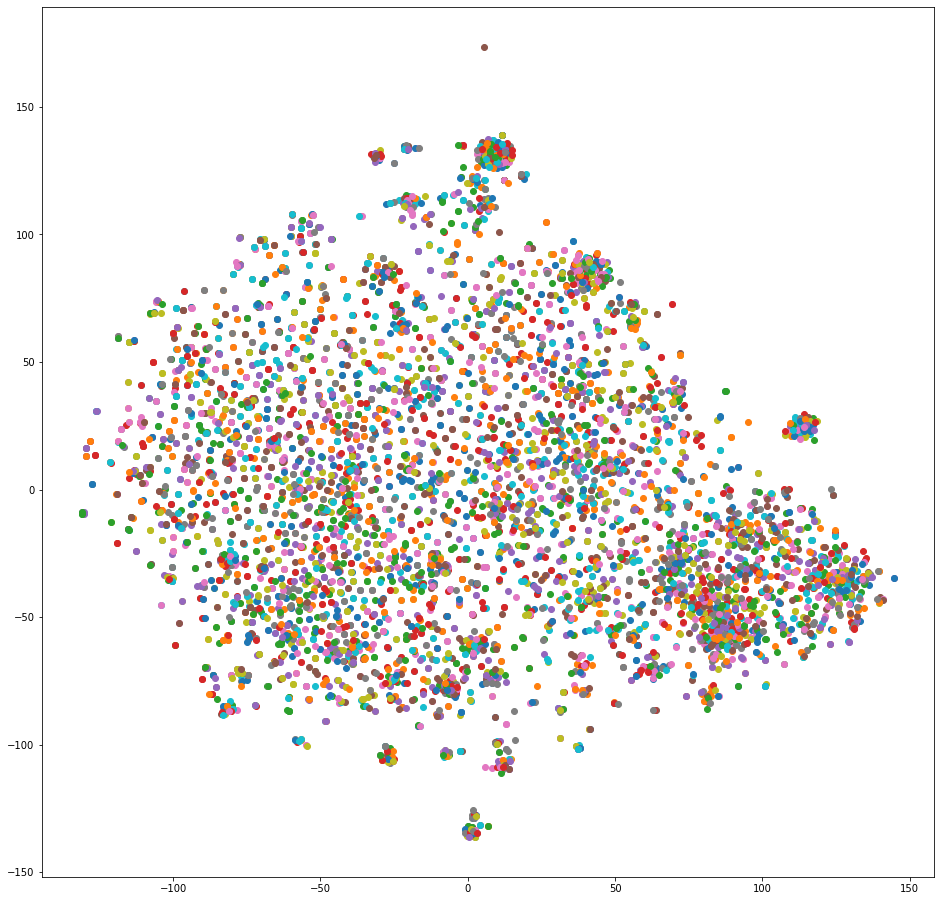

In [32]:
# The goal here is to see whether the data has any structure whatever
dim_x, dim_y = tsne_plot(embedding_tuples)

**Tensorflow Embedding Projector**

In [50]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
%load_ext tensorboard

In [51]:
import os
from tensorboard.plugins import projector
import tensorflow as tf

In [92]:
# Set up a logs directory, so Tensorboard knows where to look for files
log_dir='/logs/emb/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Save Labels separately line-by-line
with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
  for label in embedding_tuples:
    f.write("{}\n".format(label[1]))

# Save embeddings in tsv file.

with open(os.path.join(log_dir, 'vectors.tsv'), "w") as f:
  for vec in embedding_tuples:
    tmp = '\t'.join(str(x) for x in vec[0])
    f.write("{}\n".format(tmp))

In [93]:
# all embeddings as numpy array of shape [n_words, embedding_size]
arrays = [vec[0] for vec in embedding_tuples]
embeddings_vectors = np.stack(arrays, axis=0)

In [94]:
# Save embeddings in TF variable.
emb = tf.Variable(embeddings_vectors, name='word_embeddings')

# Add ops to save and restore all the variables.
checkpoint = tf.train.Checkpoint(embedding=emb)

In [95]:
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

'/logs/emb/embedding.ckpt-1'

In [96]:
# Set up config
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
# The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)

In [60]:
!kill 285

/bin/bash: line 0: kill: (285) - No such process


In [ ]:
%tensorboard --logdir /logs/emb/
#Don't forget to select PROJECTOR from the TensorBoard dropdown

**LDA - Latent Dirichle Allocation**<br>*Let's find out which topics emails are getting classified into*

In [33]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

In [34]:
#exlude stop words
stop_words = stopwords.words('english')
msgs_for_lde = [] 
for item in res['body']:
  tmp = [w for w in item.split() if w not in stop_words]
  msgs_for_lde.append(tmp)

In [37]:
#Lemmatizing
lemmatized = []
for item in msgs_for_lde:
  tmp = [wordnet_lemmatizer.lemmatize(w) for w in item]
  lemmatized.append(tmp)

In [38]:
dictionary = gensim.corpora.Dictionary(lemmatized)
bow_corpus = [dictionary.doc2bow(doc) for doc in lemmatized]

In [39]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=10, workers=2)

In [40]:
#getting a List of topics
for idx, topic in lda_model.print_topics():
  print(f'Topic: {idx} \n Top 10 Topics Words & Probabilities {topic}')

Topic: 0 
 Top 10 Topics Words & Probabilities 0.020*"I" + 0.009*"1" + 0.007*"list" + 0.007*"net" + 0.007*"message" + 0.006*"use" + 0.006*"3" + 0.005*"sourceforge" + 0.005*"mailing" + 0.004*"file"
Topic: 1 
 Top 10 Topics Words & Probabilities 0.010*"I" + 0.005*"IMAGE" + 0.005*"story" + 0.004*"The" + 0.004*"Caracas" + 0.004*"PETROLEUMWORLD" + 0.003*"50" + 0.003*"Oct" + 0.003*"00" + 0.003*"Jeff"
Topic: 2 
 Top 10 Topics Words & Probabilities 0.014*"I" + 0.006*"The" + 0.005*"would" + 0.004*"time" + 0.004*"We" + 0.003*"Enron" + 0.003*"know" + 0.003*"please" + 0.003*"Jeff" + 0.003*"If"
Topic: 3 
 Top 10 Topics Words & Probabilities 0.009*"The" + 0.006*"We" + 0.006*"Enron" + 0.004*"business" + 0.004*"I" + 0.003*"company" + 0.003*"market" + 0.003*"new" + 0.003*"United" + 0.003*"States"
Topic: 4 
 Top 10 Topics Words & Probabilities 0.012*"net" + 0.011*"sourceforge" + 0.011*"1" + 0.009*"3" + 0.008*"Exim" + 0.008*"Debian" + 0.008*"I" + 0.007*"31VAmm2" + 0.007*"id" + 0.005*"list"
Topic: 5 
 Top

In [41]:
topic_dict = {}
for item in bow_corpus:
  topic_id, prob = sorted(lda_model[item], key=lambda tup: -1*tup[1])[0]
  #print(f'topic id - {topic_id}, probability of being in the topic - {prob}')
  if topic_id not in topic_dict.keys():
    topic_dict[topic_id] = 1
  else:
    topic_dict[topic_id] +=1     
  topic_words =re.findall(r'\"(.+?)\"',lda_model.print_topic(topic_id, 5))
  #print(f'Top 5 words in topic - {topic_words}')

In [42]:
#Split words into the topics
for key, val in topic_dict.items():
  print(f'Topic ID - {key} -- Number of Docs in Topic - {val}')

Topic ID - 0 -- Number of Docs in Topic - 810
Topic ID - 6 -- Number of Docs in Topic - 690
Topic ID - 8 -- Number of Docs in Topic - 1006
Topic ID - 2 -- Number of Docs in Topic - 916
Topic ID - 9 -- Number of Docs in Topic - 546
Topic ID - 1 -- Number of Docs in Topic - 319
Topic ID - 3 -- Number of Docs in Topic - 547
Topic ID - 5 -- Number of Docs in Topic - 432
Topic ID - 7 -- Number of Docs in Topic - 894
Topic ID - 4 -- Number of Docs in Topic - 485


**K clustering**

In [43]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from gensim import corpora
from sklearn.feature_extraction.text import TfidfVectorizer

In [44]:
#List of enbeddings
X = [list(x[0]) for x in embedding_tuples]

In [45]:
# no elbow method is used, mostly because it is clear that the data doesn't have much of a structure is 
#so it is mostly to compare results to LDA
n_clusters = 10 
clf = KMeans(n_clusters=n_clusters, max_iter=100, init='k-means++', n_init=1)
# Running K-clustering on 2 dimensionl set obtained via PCA
labels_PCA = clf.fit_predict(list(zip(dim_x,dim_y)))
# Running K-clustering on 768 dimensional set of embeddings 
labels_original = clf.fit_predict(X)

In [46]:
def count_by_cluster(labels):
  clust_dict = {}
  for cluster in labels:
    if cluster not in clust_dict.keys():
      clust_dict[cluster] = 1
    else:
      clust_dict[cluster] += 1
  return clust_dict

In [47]:
# PCA Transformed Clusters
PCA_clusters = count_by_cluster(labels_PCA)
# Original Embedding Clusters
Emb_clusters = count_by_cluster(labels_original)
# DLA Distribution by Topic
Topic_clusters = count_by_cluster(labels_original)

In [48]:
clust_dict = {}
for cluster in labels:
  if cluster not in clust_dict.keys():
    clust_dict[cluster] = 1
  else:
    clust_dict[cluster] += 1

**Comparing the grouping by DLA and K-Clustering**

In [49]:
#just to sort for easier comparing
def dict_to_tuple(dct):
  tuples = []
  for key, value in dct.items():
    tuples.append((value, key))
  return tuples  

In [50]:
k_means_tuples_PCA = dict_to_tuple(PCA_clusters)
k_means_tuples_EMB = dict_to_tuple(Emb_clusters)
DLA_tuples = dict_to_tuple(topic_dict)
#Results are sorted by the cluster size, the second element of taple is Cluster ID
print(f'Data Clusters after PCA - {sorted(k_means_tuples_PCA)}')
print(f'Data Cluster based on 768 dimensonal embeddings - {sorted(k_means_tuples_EMB)}')
print(f'Data Cluster based on DLA Topics - {sorted(DLA_tuples)}')

Data Clusters after PCA - [(432, 0), (625, 7), (638, 8), (639, 9), (678, 2), (681, 4), (706, 6), (728, 5), (736, 1), (782, 3)]
Data Cluster based on 768 dimensonal embeddings - [(100, 2), (370, 4), (513, 0), (516, 5), (703, 3), (768, 1), (792, 9), (821, 7), (950, 8), (1112, 6)]
Data Cluster based on DLA Topics - [(319, 1), (432, 5), (485, 4), (546, 9), (547, 3), (690, 6), (810, 0), (894, 7), (916, 2), (1006, 8)]


# Sandbox

In [103]:
#TF-IDF Calculation
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(res['body'])

In [108]:
X[5].toarray()

array([[0., 0., 0., ..., 0., 0., 0.]])

In [221]:
X = [list(x[0]) for x in embedding_tuples]
X = np.array(X)
pca = PCA(n_components=2)
coords = pca.fit_transform(X)

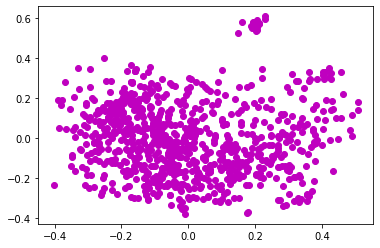

In [242]:
plt.scatter(coords[:, 0], coords[:, 1], c='m')
plt.show()

In [ ]:
#test read to be deleted
with open('./contacts/1462.copy', 'r',encoding='utf-8-sig') as file:
    data = file.read()

In [13]:
paths = Path('./Alaffia_Data').glob('**/[!.]*.*')
#paths = Path('/content/all_documents').glob('**/[!.]*')
msg = []
file_path = []

# Not a very elegant code. For whatever reason this is the only way Pathlib works with CoLab. Somehow io.open refuses 
#to properly interpet path object for some of the nested folders, probably some minor config problem.  I chose to ignore it for now 
for path in paths:
    path_in_str = str(path)
    file_path.append(path_in_str)
for item in file_path:    
    with io.open(item, 'r', errors='ignore') as file:
      msg.append(file.read())

In [ ]:
#preview - for testing only
for i in range(len(bow_corpus[1])):
  print("Word {} (\"{}\") appears {} time.".format(bow_corpus[1][i][0],dictionary[bow_corpus[1][i][0]],bow_corpus[1][i][1]))